In [153]:
import pandas as pd
import importlib
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
podData = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthEnSHORT.csv",lineterminator='\n')

/tmp/ipykernel_4146555/709379184.py:1: DtypeWarning: Columns (6,7,8,12,20,49) have mixed types. Specify dtype option on import or set low_memory=False.
  podData = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthEnSHORT.csv",lineterminator='\n')


In [8]:
#just to make run faster at first 
podData = podData.head(100000)

In [15]:
#get function to give transcript file path of urls
spec=importlib.util.spec_from_file_location("getURLstorageLocation","/home/blitt/projects/podcasts/mergeTransMetadata/getURLstorageLocation.py")
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)

#get path to transcripts for each url 
META_PATH= "/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth"
podData = podData.dropna(subset=["enclosure"])
podData["potentialOutPath"] = podData["enclosure"].apply(foo.getUrlTranscriptPath, args=[META_PATH])

/tmp/ipykernel_4146555/3100014144.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  podData["potentialOutPath"] = podData["enclosure"].apply(foo.getUrlTranscriptPath, args=[META_PATH])


In [ ]:
#get function to give transcript file path of urls
spec=importlib.util.spec_from_file_location("getURLstorageLocation","/home/blitt/projects/podcasts/mergeTransMetadata/getURLstorageLocation.py")
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)

#get path to transcripts for each url 
META_PATH= "/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth"
podData = podData.dropna(subset=["enclosure"])
podData["transcriptPath"] = podData["enclosure"].apply(foo.getUrlTranscriptPath, args=[META_PATH])

In [ ]:
#we can only work with the data for which we have transcripts/embeddings 
podData["exists"] = podData["potentialOutPath"].apply(os.path.exists)
podData = podData[podData["exists"] == True]

In [27]:
#get all of the titles, then find references to those titles 
podNames = set(podData["title"].str.lower().unique())

In [205]:
#get substrings starting with capital letters 
def getCapStrs(inStr):   
    #get indices of capital letters 
    capIndices = [i for i in range(len(inStr)) if inStr[i].isupper()]
    
    #grab all strings starting with capital letters, get 40 characters 
    #return re.findall("(?:\s|\w){2}[A-Z].{40}", inStr)

    outStrs = []
    for i in capIndices: 
        BUFFER = 40 
        if i + BUFFER < len(inStr): 
            outStr = inStr[i: i+40]
        else: 
            outStr = inStr[i: len(inStr)]

        if i - 2 > 0 and "." not in inStr[i-2:i] and "!" not in inStr[i-2:i]: 
            outStrs.append(outStr)
            
    return outStrs

In [206]:
testStr = 'Its June 4" 2020. And in light of the national response to the death of. George Floyd and so many other unarmed African Americans" weve decided to postpone our episode about Nirvana and make more space for Black voices to be heard. '
getCapStrs(testStr)

['June 4" 2020. And in light of the nation',
 'Floyd and so many other unarmed African ',
 'African Americans" weve decided to postp',
 'Americans" weve decided to postpone our ',
 'Nirvana and make more space for Black vo',
 'Black voices to be heard. ']

In [207]:
def searchPodNames(inStr): 
    matches = []
    splitStr = inStr.split()
    splitLen = len(splitStr) 
    for i in range(splitLen): 
        subStr = " ".join(splitStr[:i+1]) 
        if subStr.lower() in podNames: 
            #print("yep!")
            matches.append(subStr) 
    return matches 

#example: 
searchPodNames('t Hello and welcome to Secrets of Organ Pla'[2:]) 

[]

In [208]:
#let's merge the podcast text into the data 
inPaths = podData["potentialOutPath"]
matchesList = []
for path in tqdm(inPaths[:20000]): 
    matches = []
    with open(path, "r") as handle: 
        currText = "".join([row.split(",")[4] for row in handle.readlines()])
        capStrings = getCapStrs(currText)
        for capStr in capStrings: 
            matches += searchPodNames(capStr)
        matchesList.append(matches) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:15<00:00, 45.90it/s]


In [209]:
"Secrets of Organ Playing Podcast".lower() in podNames

True

In [210]:
sampDf = podData.head(20000)

In [211]:
sampDf["references"] = matchesList

/tmp/ipykernel_4146555/930718568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampDf["references"] = matchesList


In [212]:
edgeDf = sampDf[["title", "epTitle", "references", "cleanDates"]] 

In [213]:
longEdges = edgeDf.explode("references").dropna(subset=["references"])

In [214]:
refCounts = pd.DataFrame(longEdges["references"].value_counts()).reset_index()
refCounts["refProp"] = refCounts["count"] / sum(refCounts["count"]) 

In [215]:
refCounts[refCounts["refProp"] < .00005] 

,references,count,refProp
512,Sporty,4,0.000050
513,Let's unpack,4,0.000050
514,RCR Wireless News,4,0.000050
515,Beyond Homosapien,4,0.000050
516,Financial Choices Matter,4,0.000050
...,...,...,...
1894,Knitting Nerdcast,1,0.000012
1895,Lore Party,1,0.000012
1896,Imago Church,1,0.000012
1897,Unscripted,1,0.000012


In [216]:
longEdges = pd.merge(longEdges, refCounts, on="references", how="left") 

<Axes: xlabel='refProp', ylabel='Density'>

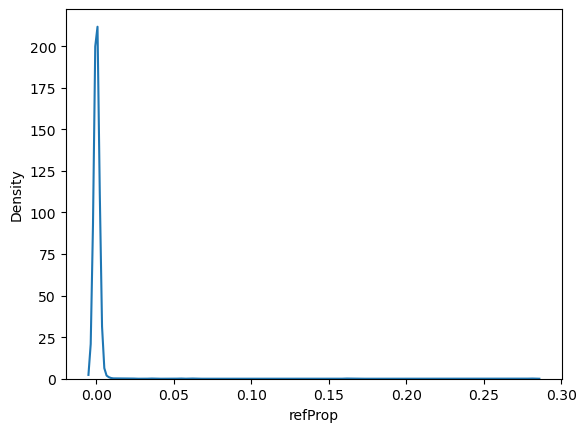

In [217]:
sns.kdeplot(data = refCounts, x="refProp")

In [218]:
longEdges[longEdges["title"] == longEdges["references"]]

,title,epTitle,references,cleanDates,count,refProp
105,Inspired Marketing,Inspired Marketing: Uberflip’s Randy Frisch on...,Inspired Marketing,2020-05-27 09:00:00+00:00,1,0.000012
160,What's in the Words,Letting Go,What's in the Words,2020-06-04 11:50:27,3,0.000037
164,What's in the Words,Started from the Bottom,What's in the Words,2020-05-19 04:00:00,3,0.000037
167,What's in the Words,The Truth About Black History,What's in the Words,2020-05-18 21:53:25,3,0.000037
201,DadGab,It Started with a Door Handle,DadGab,2020-06-02 14:03:07-05:00,4,0.000050
...,...,...,...,...,...,...
79998,Practical Consciousness,Episode 28 - Practical Mindfulness Practice,Practical Consciousness,2020-05-18 19:25:03,10,0.000125
79999,Practical Consciousness,Episode 28 - Practical Mindfulness Practice,Practical Consciousness,2020-05-18 19:25:03,10,0.000125
80000,Practical Consciousness,Episode 28 - Practical Mindfulness Practice,Practical Consciousness,2020-05-18 19:25:03,10,0.000125
80001,Practical Consciousness,Episode 27 - The Three Kinds of Awareness,Practical Consciousness,2020-05-13 20:52:10,10,0.000125


In [219]:
len(longEdges[longEdges["references"].str.contains("Podcast")])

241

In [220]:
#TODO: as an example, see if these are legit references... doesn't seem like it!
#TODO: and think about how we can pare this down 
longEdges[longEdges["references"] == "Stay well"]

,title,epTitle,references,cleanDates,count,refProp
71083,Focus Fox Valley,Focus Fox Valley with Hayley Tenpas 05/26 /20,Stay well,2020-05-26 23:12:11+00:00,1,0.000012


In [232]:
currPath.item()

'/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth/dts.podtrac.com/e_/httpsdts.podtrac.comredirect.mp3api.spreaker.comdownloadepisode28394329focus_fox_valley_with_hayley_tenpas_05_26_20.mp3MERGED'

In [238]:
#this "Stay well" is a false positive
currPath = podData.loc[podData["epTitle"] == "Focus Fox Valley with Hayley Tenpas 05/26 /20", "potentialOutPath"].item()
currText = "".join([row.split(",")[4] for row in open(currPath, "r").readlines()])
subStrI = currText.find("Stay well") 
currText[subStrI - 30:subStrI + 30]

' the future. - Thanks" Haley. Stay well. - Stay well to you '

In [239]:
longCands = longEdges.loc[(longEdges["references"] != longEdges["title"]) & (longEdges["count"] <= 400 )]

In [240]:
longCands[longCands["references"].apply(lambda x: len(x.split())) >= 3]

,title,epTitle,references,cleanDates,count,refProp
135,We Love Tech Podcast,Should you upgrade to the MacBook Pro 13 ? Als...,We Love Tech podcast,2020-05-18 21:54:11,1,0.000012
144,FFGF Podcast,The Limp of God,You know what I mean?,2020-05-28 19:45:23+00:00,363,0.004537
156,ZION ID,Healing: Part One,I have no idea,2020-05-23 16:06:33,383,0.004787
195,From Chicago to Dummast,The Dummast Podcast Ep.6: Goldblum's Inner Lot...,This is why,2020-05-17 02:32:46-05:00,83,0.001037
205,5G Talent Talk with Carrie Charles,How Samsung is Staying Ahead of Tomorrow with ...,RCR Wireless News,2020-06-05 22:03:00,4,0.000050
...,...,...,...,...,...,...
79786,Look On The Bright Side,"Hamper for Heroes, Keep Pubs Pumping and Can Y...",Look on the Bright Side,2020-05-20 23:00:00,4,0.000050
79788,Look On The Bright Side,"Hamper for Heroes, Keep Pubs Pumping and Can Y...",Look on the Bright Side,2020-05-20 23:00:00,4,0.000050
79792,Look On The Bright Side,"Tailor made support, Hypnosis and a Swiss Hack...",Look on the Bright Side,2020-05-13 23:00:00,4,0.000050
79798,Just James Podcast,Episode 15: Friendship break-ups are hard to do!,Just James podcast,2020-05-20 15:00:00+01:00,1,0.000012


In [ ]:
longCands.iloc[120809]

In [ ]:
#probably best to just go with named entities...